In [26]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.table import Table
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.visualization.wcsaxes import add_scalebar
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

### Load catalogs

In [27]:
field = 'GDS'
with fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/*sci_cutout_cutout_assoc_sepp_cat.fits")[0]) as hdul:
    phot_sepp = Table(hdul[1].data)

In [28]:
print(f"Sources in DJA catalog  : {len(phot_dja)}")
print(phot_dja.keys())
print(f"Sources in SE++ catalog : {len(phot_sepp)}")
print(phot_sepp.keys())

Sources in DJA catalog  : 70357
['id', 'thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2_image', 'y2_image', 'xy_image', 'errxy', 'a_image', 'b_image', 'theta_image', 'cxx_image', 'cyy_image', 'cxy_image', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag', 'x_image', 'y_image', 'number', 'ra', 'dec', 'x_world', 'y_world', 'flux_iso', 'fluxerr_iso', 'area_iso', 'mag_iso', 'kron_radius', 'kron_rcirc', 'flux_auto', 'fluxerr_auto', 'bkg_auto', 'flag_auto', 'area_auto', 'flux_radius_flag', 'flux_radius_20', 'flux_radius', 'flux_radius_90', 'tot_corr', 'mag_auto', 'magerr_auto', 'flux_aper_0', 'fluxerr_aper_0', 'flag_aper_0', 'bkg_aper_0', 'mask_aper_0', 'flux_aper_1', 'fluxerr_aper_1', 'flag_aper_1', 'bkg_aper_1', 'mask_aper_1', 'clearp-f430m_flux_aper_0', 'clearp-f430m_fluxerr_aper_0', 'clearp-f430m_flag_aper_0', 'clearp-f430m_bkg_aper_0', 'clearp-f430m_mask_aper_0', 'clearp-f430m_flux_aper_1', 'clearp-f430m_fluxerr_aper_1', 'clearp-f430m

### Plot position of objects

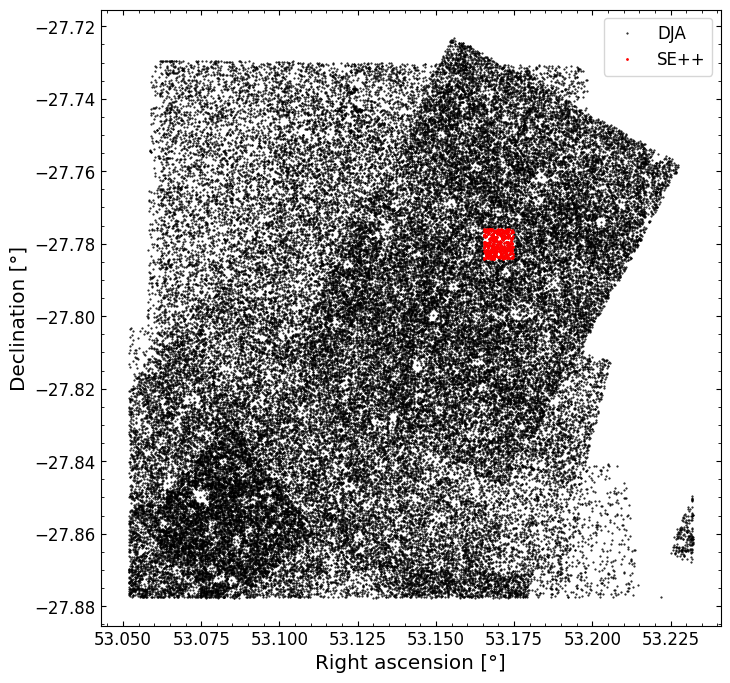

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_sepp['world_centroid_alpha'], phot_sepp['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label='SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
ax.legend()
plt.show()

### Cross match catalogs

In [30]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sepp = SkyCoord(phot_sepp['world_centroid_alpha']*u.degree, phot_sepp['world_centroid_delta']*u.degree)
idx, d2d, _ = coord_sepp.match_to_catalog_sky(coord_dja)

### Remove false matches

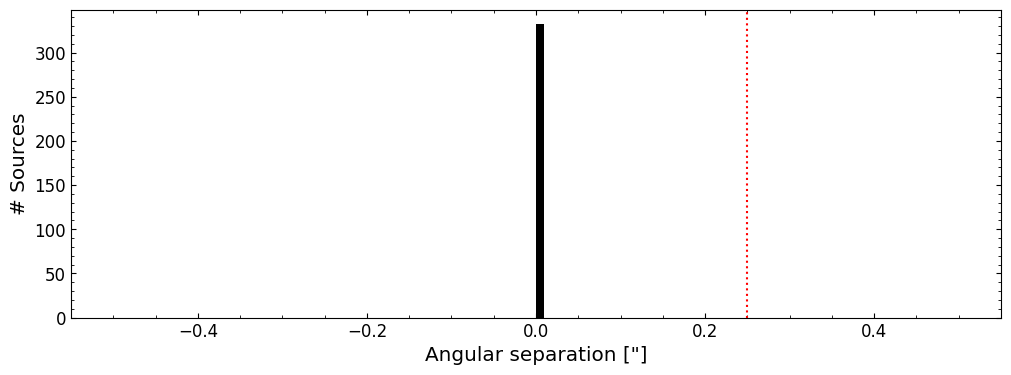

In [31]:
max_sep = 0.25*u.arcsec
phot_dja_match = phot_dja[idx][d2d<max_sep]
phot_sepp_match = phot_sepp[d2d<max_sep]

fig, ax = plt.subplots(figsize=(12,4))
ax.hist(d2d.to(u.arcsec), bins=100, color='k')
ax.axvline(max_sep.value, color='r', ls=':')
ax.set_xlabel('Angular separation ["]')
ax.set_ylabel('# Sources')
plt.show()

### Magnitude comparison

/tmp/ipykernel_7270/4151367604.py:35: RuntimeWarning: invalid value encountered in log10
  mag_sepp = ZP - 2.5*np.log10(phot_sepp_match[f'FLUX_MODEL_{filter.upper()}']*10)
/tmp/ipykernel_7270/4151367604.py:36: RuntimeWarning: invalid value encountered in log10
  mag_dja = ZP - 2.5*np.log10(phot_dja_match[f'{filter}_tot_1']*1000)


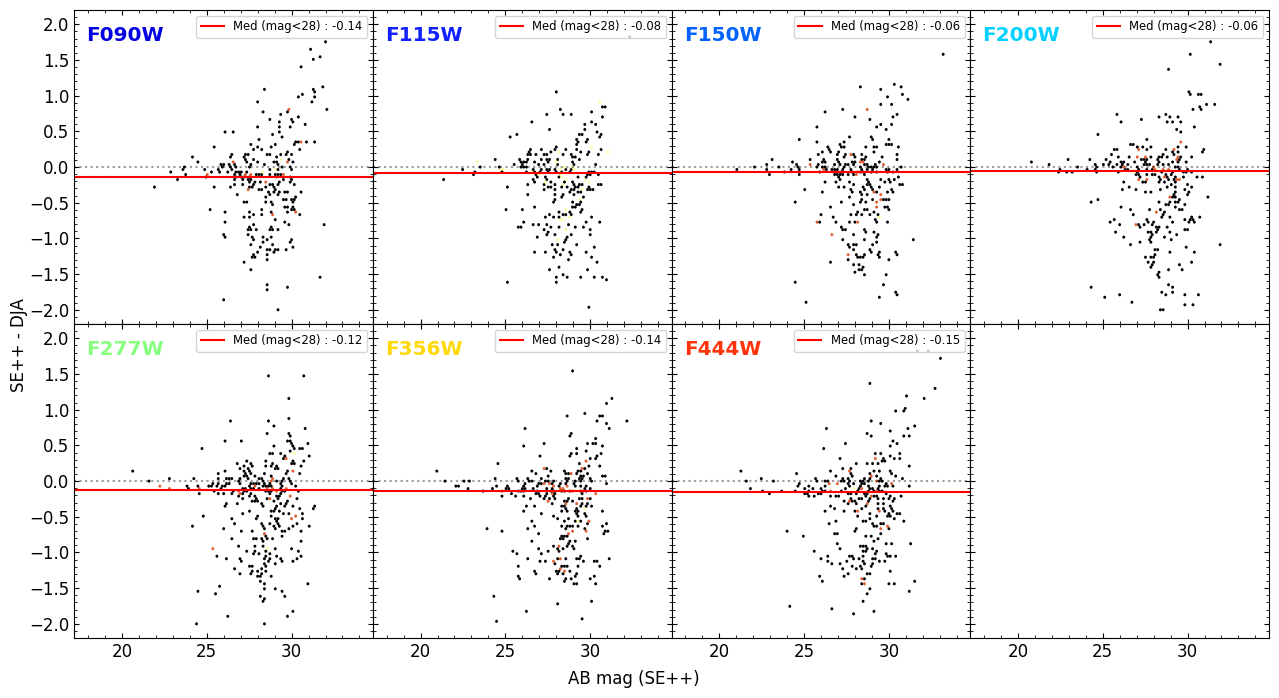

In [32]:
# filter_list = ['f090w', 'f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m', 'f444w']
# filter_list = ['f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f356w', 'f410m', 'f444w']
filter_list = [key.split("_")[-1].lower() for key in phot_sepp.keys() if (('MAG' in key) and ('err' not in key))]
filter_list.sort()

color_dict = {'F090W':'#0000E3', 
              'F115W':'#1020FF',
              'F150W':'#0162FF',
              'F182M':'#00B1FF',
              'F200W':'#04D1FF',
              'F210M':'#02E8F4',
              'F277W':'#87FF7F',
              'F335M':'#EBFF0C',
              'F356W':'#FFD807',
              'F410M':'#FF6D03',
              'F444W':'#FF330C',}
channel_dict = {'F090W':'SW', 'F115W':'SW', 'F150W':'SW', 'F182M':'SW', 'F200W':'SW', 'F210M':'SW',
                'F277W':'LW', 'F335M':'LW', 'F356W':'LW', 'F410M':'LW', 'F444W':'LW',}
channel, count = np.unique([channel_dict[filter.upper()] for filter in filter_list], return_counts=True)
channel_count = dict(zip(channel, count))

w = channel_count[max(channel_count, key=channel_count.get)]
h = len(channel_count)

ZP = (1*u.nJy).to(u.ABmag).value

fig, axs = plt.subplots(h,w,figsize=(3*w+1,3*h+1), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, filter in enumerate(filter_list):
    if (len(channel_count)==2) & (channel_dict[filter.upper()]=="LW"):
        i += max(0, channel_count["LW"]-channel_count["SW"])
    ax = axs.flatten()[i] if type(axs)==np.ndarray else axs

    ax.axhline(0, color='k', alpha=0.4, ls=':')
    mag_sepp = ZP - 2.5*np.log10(phot_sepp_match[f'FLUX_MODEL_{filter.upper()}']*10)
    mag_dja = ZP - 2.5*np.log10(phot_dja_match[f'{filter}_tot_1']*1000)
    delta_28 = np.nanmedian((mag_sepp-mag_dja)[mag_sepp<28])

    ax.hexbin(mag_sepp, mag_sepp - mag_dja, mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(18,34,-2,2), lw=0.01)
    ax.axhline(delta_28, color='r', label=f"Med (mag<28) : {delta_28:.2f}")
    ax.text(0.04, 0.9, filter.upper(), transform=ax.transAxes, fontsize='x-large', fontweight='bold', color=color_dict[filter.upper()])
    ax.legend(loc='upper right', fontsize='small')

fig.supylabel("SE++ - DJA")
fig.supxlabel("AB mag (SE++)")
fig.tight_layout(rect=(0.01, -0.02, 1.0, 1.0))
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/{field}_DJAvSEpp.pdf", bbox_inches='tight')
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/{field}_DJAvSEpp.png", bbox_inches='tight', dpi=200)
plt.show()

### Morphological distributions

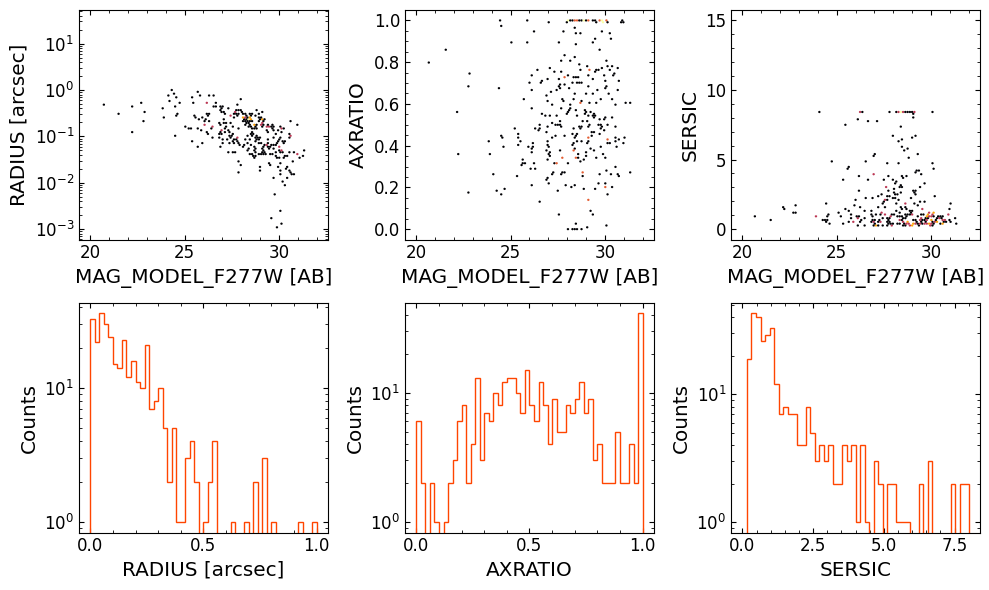

In [16]:
filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(phot_sepp_match[f'MAG_MODEL_{filter.upper()}'], phot_sepp_match['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,1.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(phot_sepp_match[f'MAG_MODEL_{filter.upper()}'], phot_sepp_match['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(phot_sepp_match[f'MAG_MODEL_{filter.upper()}'], phot_sepp_match['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,15), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(phot_sepp_match['RADIUS']*3600, bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(phot_sepp_match['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(phot_sepp_match['SERSIC'], bins=50, range=(0,8), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"/home/ec2-user/DAWN/DJA-SEpp/validation-images/6_SEpp-morphology/{field}_Sepp-morphology.png", bbox_inches='tight', dpi=200)
plt.show()

### Sample looking

In [19]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, corner='bottom_right', pad=0.1):
    width = abs(proj_plane_pixel_scales(wcs)[0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size='x-large'), label_top=True, pad=pad, corner=corner)

def show_source(id, cat, field):
    target = SkyCoord(cat['world_centroid_alpha'][id], cat['world_centroid_delta'][id], frame='icrs', unit='deg')
    size = u.Quantity((3.3,3.3), u.arcsec)

    fig = plt.figure(figsize=(2*len(filter_list)+1,2*3+0.5))
    for i, filter in enumerate(filter_list):
        # Loads images
        hdu       = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*{filter}*sci_cutout_cutout.fits")[0], memmap=True)[0]
        model_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages/model*{filter}*cutout_cutout*.fits")[0], memmap=True)[0]
        resid_hdu = fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/sepp/{field}/checkimages/resid*{filter}*cutout_cutout*.fits")[0], memmap=True)[0]
        wcs = WCS(hdu.header)
        # Cutouts in images
        cutout       = Cutout2D(hdu.data,       position=target, size=size, wcs=wcs)
        model_cutout = Cutout2D(model_hdu.data, position=target, size=size, wcs=wcs)
        resid_cutout = Cutout2D(resid_hdu.data, position=target, size=size, wcs=wcs)
        #Plots data
        ax = fig.add_subplot(3,len(filter_list),i+1, projection=cutout.wcs)
        norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
        # norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
        ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
        add_good_scalebar(ax, cutout.wcs, fraction=1.0, corner='bottom')
        ax.set_title(filter.upper(), fontsize=24)
        ax.set_axis_off()
        # Plots model
        ax_model = fig.add_subplot(3,len(filter_list),i+len(filter_list)+1, projection=cutout.wcs)
        ax_model.imshow(model_cutout.data, cmap='gray', origin='lower', norm=norm)
        ax_model.set_axis_off()
        # Plots residual
        ax_resid = fig.add_subplot(3,len(filter_list),i+2*len(filter_list)+1, projection=cutout.wcs)
        ax_resid.imshow(resid_cutout.data, cmap='gray', origin='lower', norm=norm)
        ax_resid.set_axis_off()
    plt.figtext(1.0, 0.79, "Data", figure=fig, va='center', ha='left', rotation='vertical', fontsize='xx-large')
    plt.figtext(1.0, 0.48, "Model", figure=fig, va='center', ha='left',rotation='vertical', fontsize='xx-large')
    plt.figtext(1.0, 0.17, "Residual", figure=fig, va='center', ha='left',rotation='vertical', fontsize='xx-large')
    plt.figtext(0.0, 0.48, f"Source #{id}", figure=fig, va='center', ha='right', rotation='vertical', fontsize=24)
    fig.tight_layout()
    plt.show()

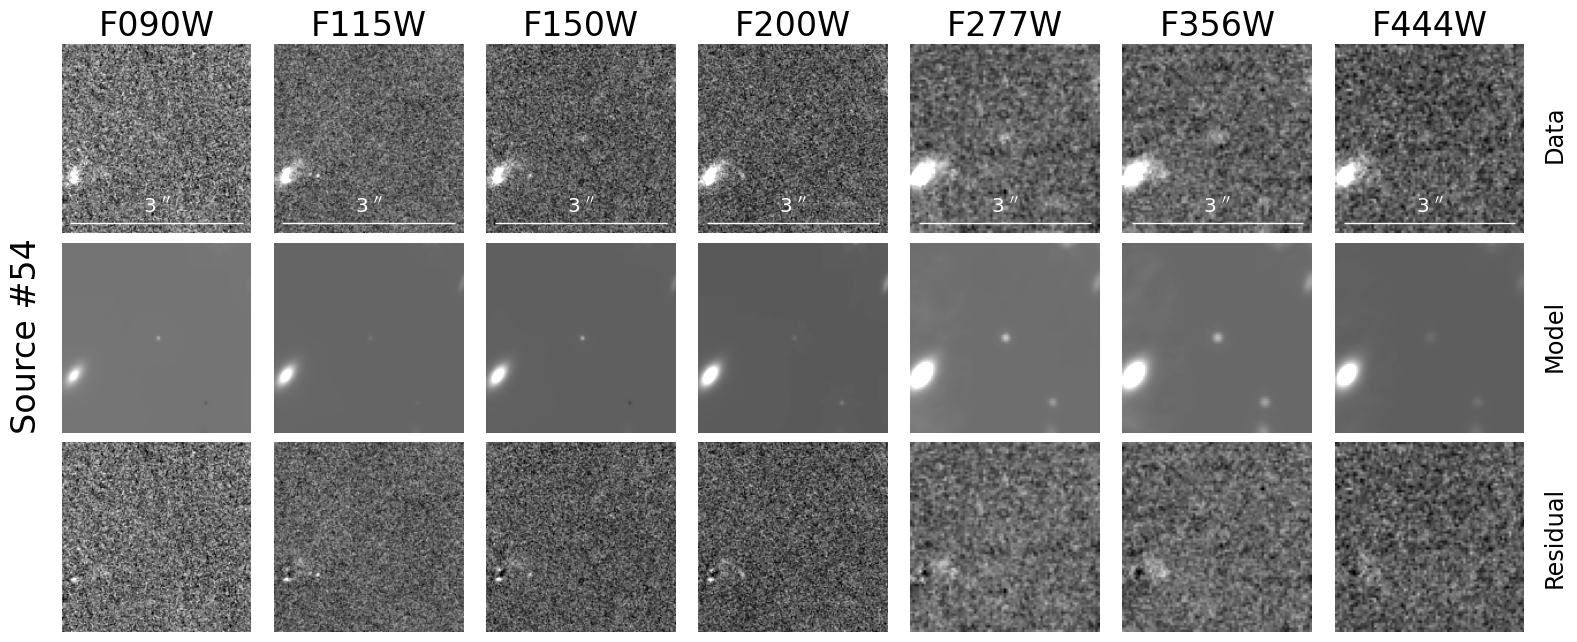

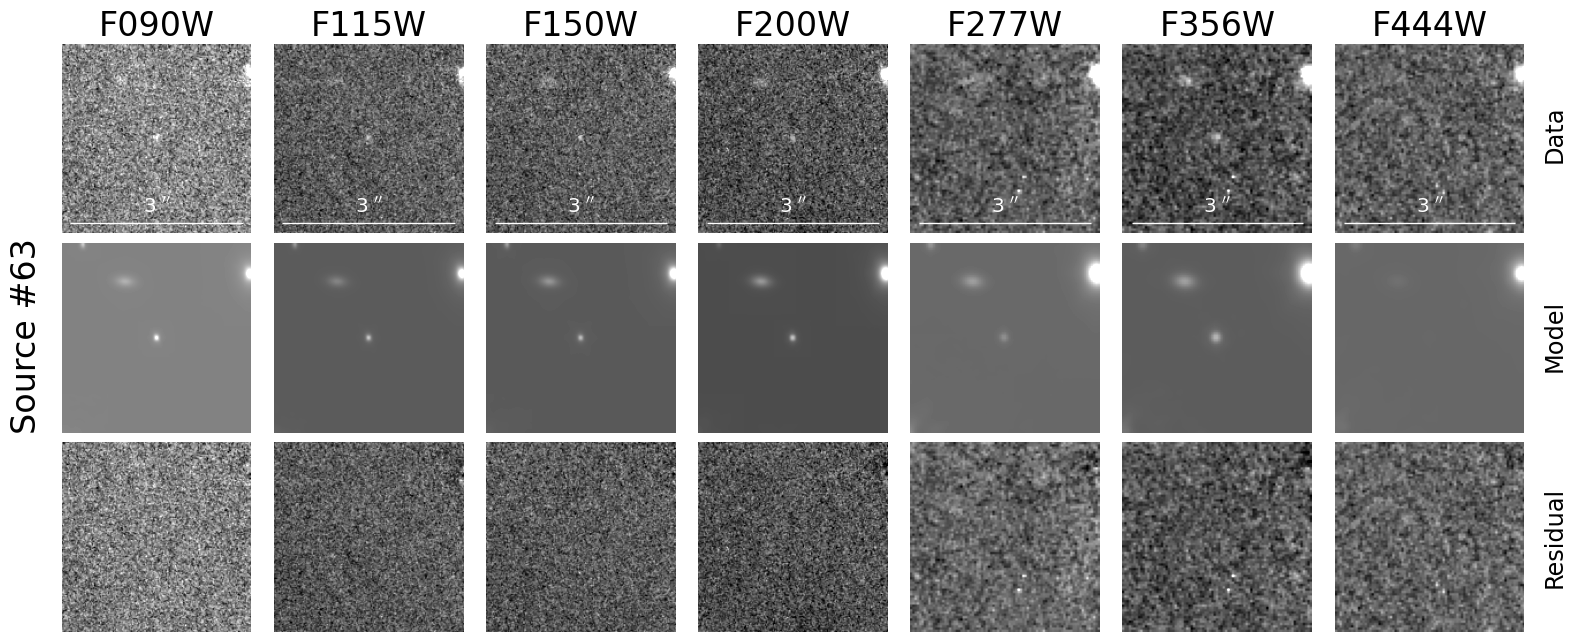

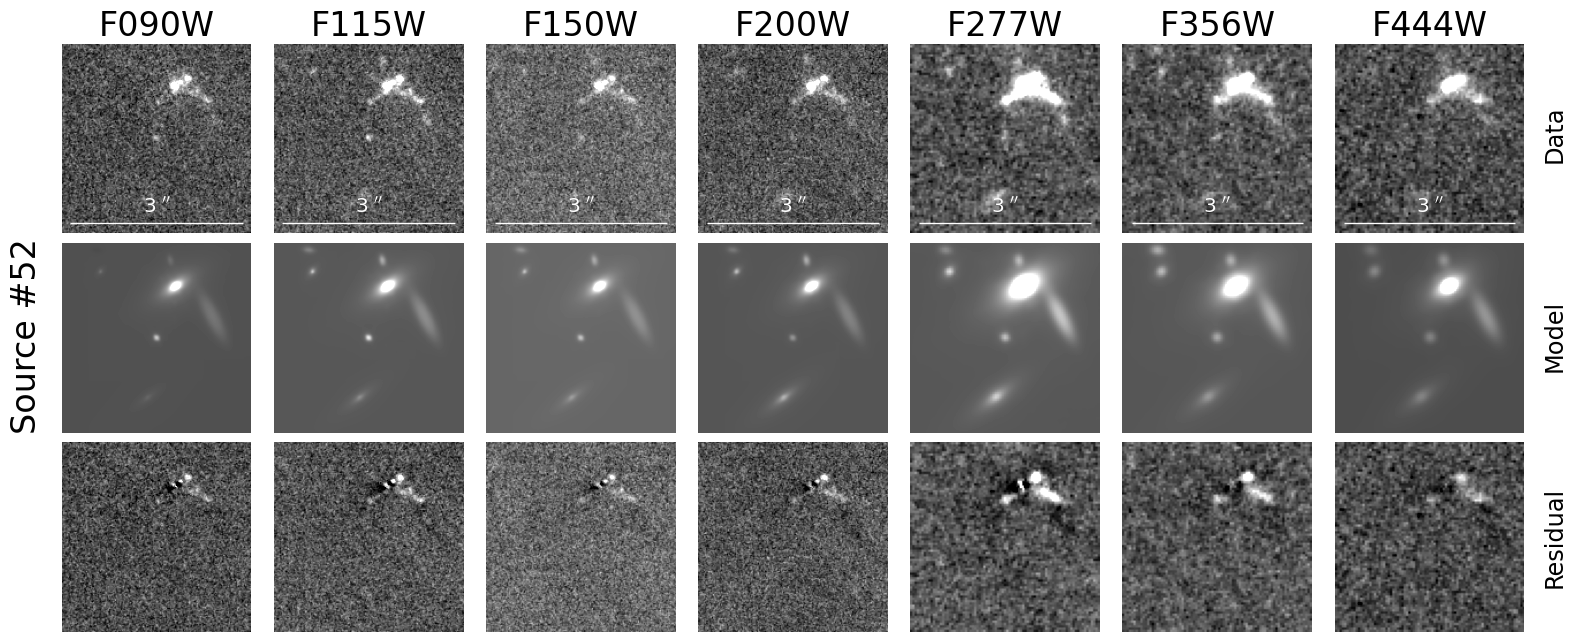

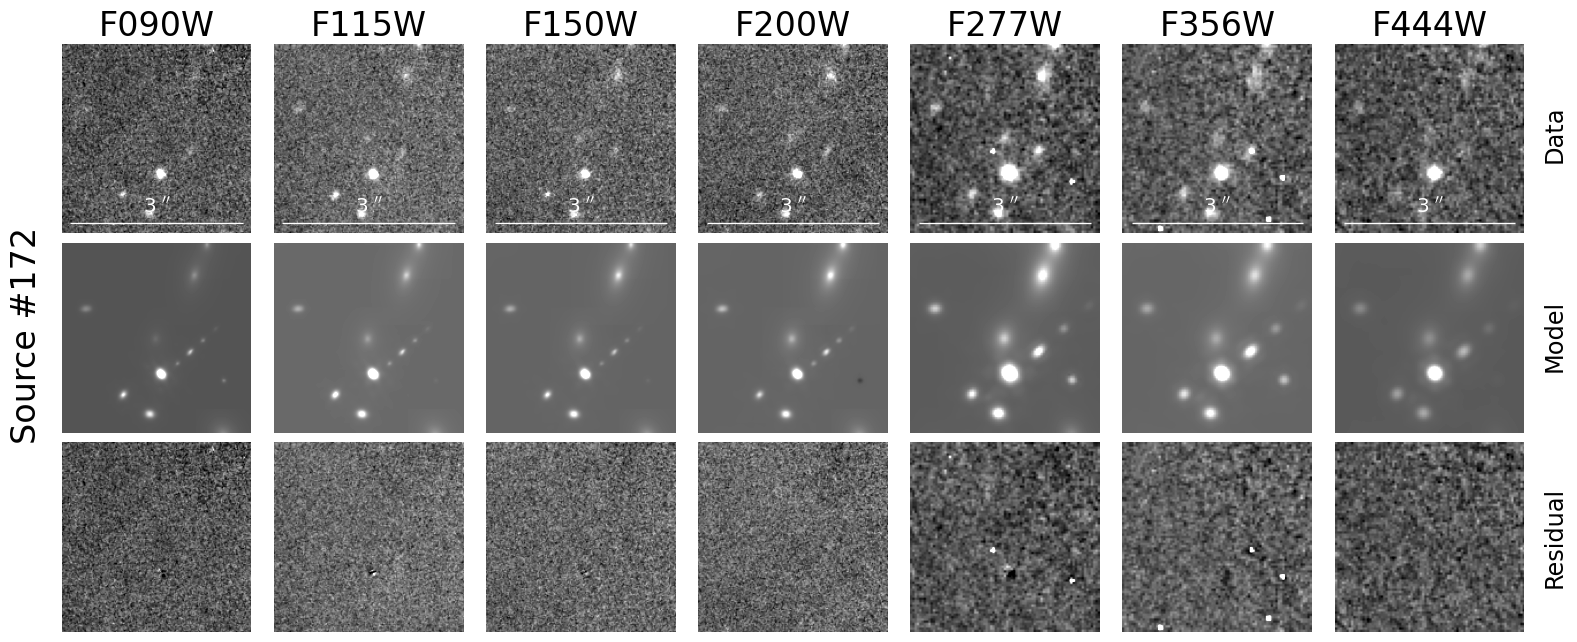

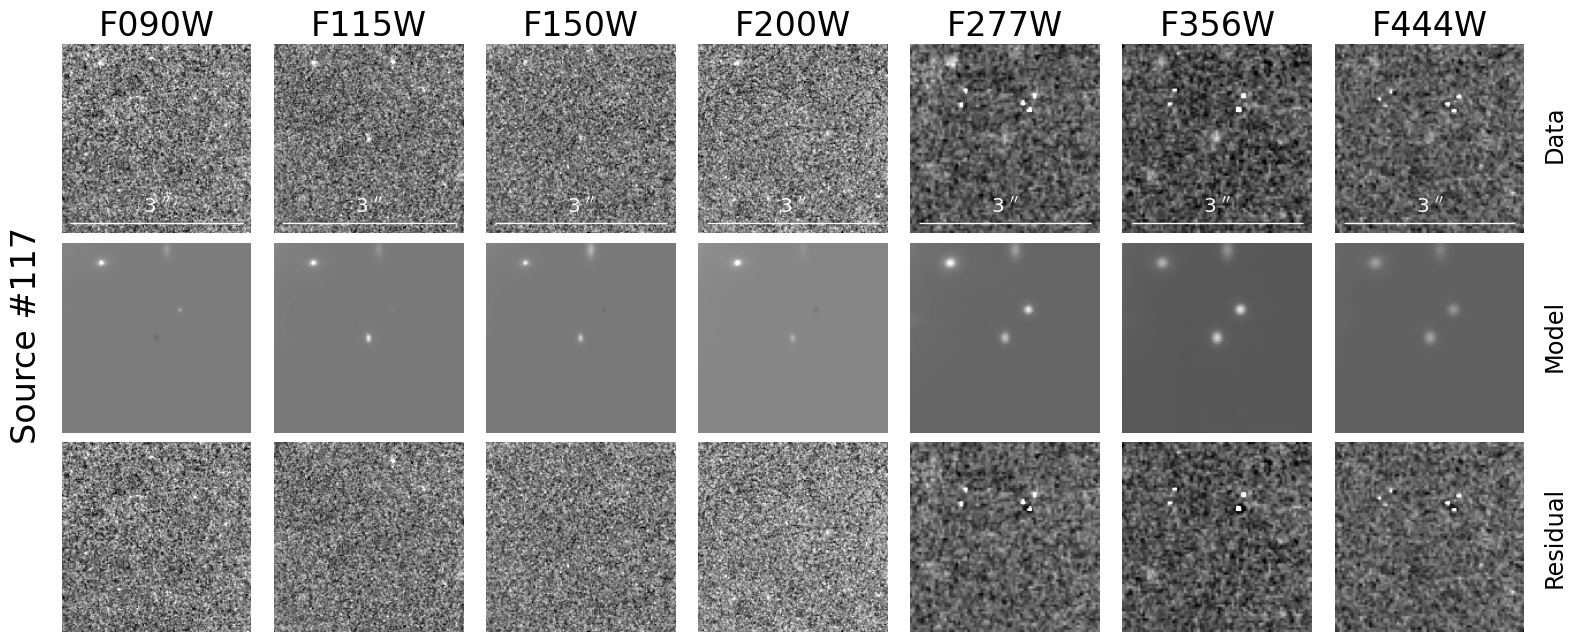

In [20]:
for id in np.random.randint(0, len(phot_sepp_match), 5):
    show_source(id, phot_sepp_match, field)

### Initial fit parameters comparison

In [21]:
# assoc_values : ra, dec, group_id, flux_mean, mag_mean, a_image, b_image, theta_image, axratio, bigsize

/tmp/ipykernel_7270/911749445.py:9: RuntimeWarning: invalid value encountered in log10
  mag_sepp = ZP - 2.5*np.log10(phot_sepp_match[f'FLUX_MODEL_{filter.upper()}']*10)
/tmp/ipykernel_7270/911749445.py:11: RuntimeWarning: invalid value encountered in log10
  mag_dja = ZP - 2.5*np.log10(phot_dja_match[f'{filter}_tot_1']*1000)


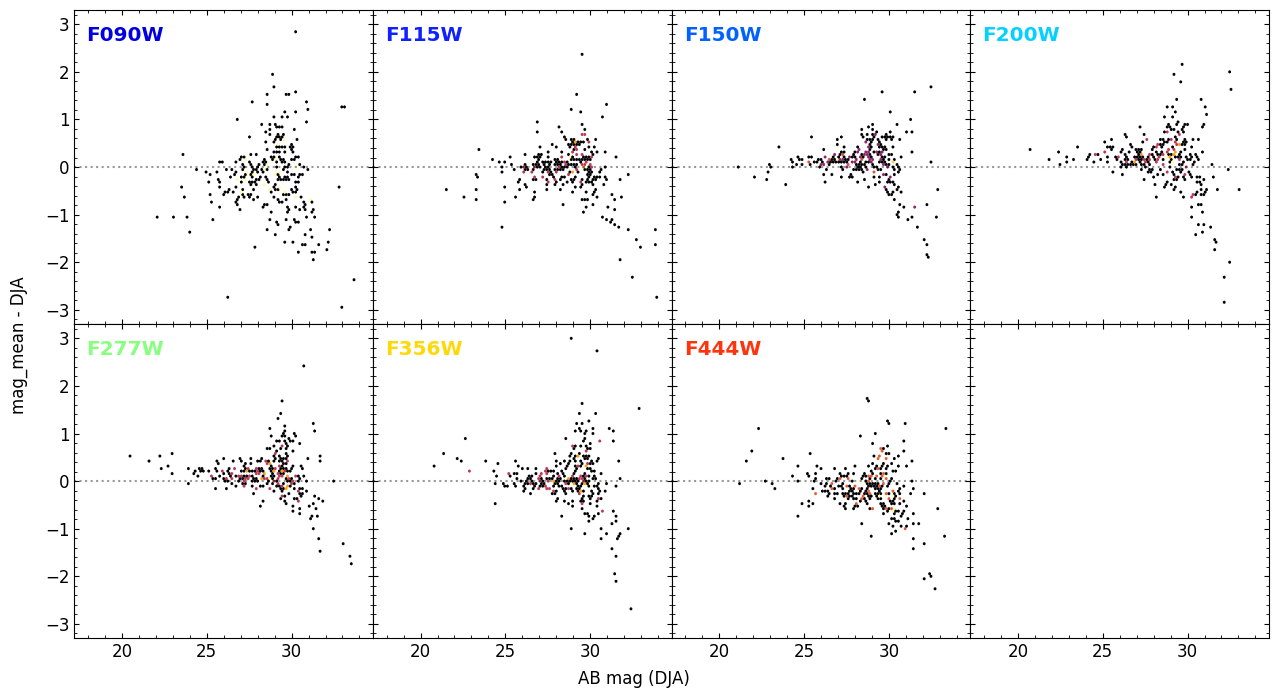

In [23]:
fig, axs = plt.subplots(h,w,figsize=(3*w+1,3*h+1), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, filter in enumerate(filter_list):
    if (len(channel_count)==2) & (channel_dict[filter.upper()]=="LW"):
        i += max(0, channel_count["LW"]-channel_count["SW"])
    ax = axs.flatten()[i] if type(axs)==np.ndarray else axs

    ax.axhline(0, color='k', alpha=0.4, ls=':')
    mag_sepp = ZP - 2.5*np.log10(phot_sepp_match[f'FLUX_MODEL_{filter.upper()}']*10)
    mag_assoc = phot_sepp_match['assoc_values'][:,4]
    mag_dja = ZP - 2.5*np.log10(phot_dja_match[f'{filter}_tot_1']*1000)
    # delta_28 = np.nanmedian((mag_sepp-mag_dja)[mag_sepp<28])

    ax.hexbin(mag_dja, mag_assoc - mag_dja, mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(18,34,-3,3), lw=0.01)
    # ax.axhline(delta_28, color='r', label=f"Med (mag<28) : {delta_28:.2f}")
    ax.text(0.04, 0.9, filter.upper(), transform=ax.transAxes, fontsize='x-large', fontweight='bold', color=color_dict[filter.upper()])
    # ax.legend(loc='upper right', fontsize='small')

fig.supylabel("mag_mean - DJA")
fig.supxlabel("AB mag (DJA)")
fig.tight_layout(rect=(0.01, -0.02, 1.0, 1.0))
plt.show()

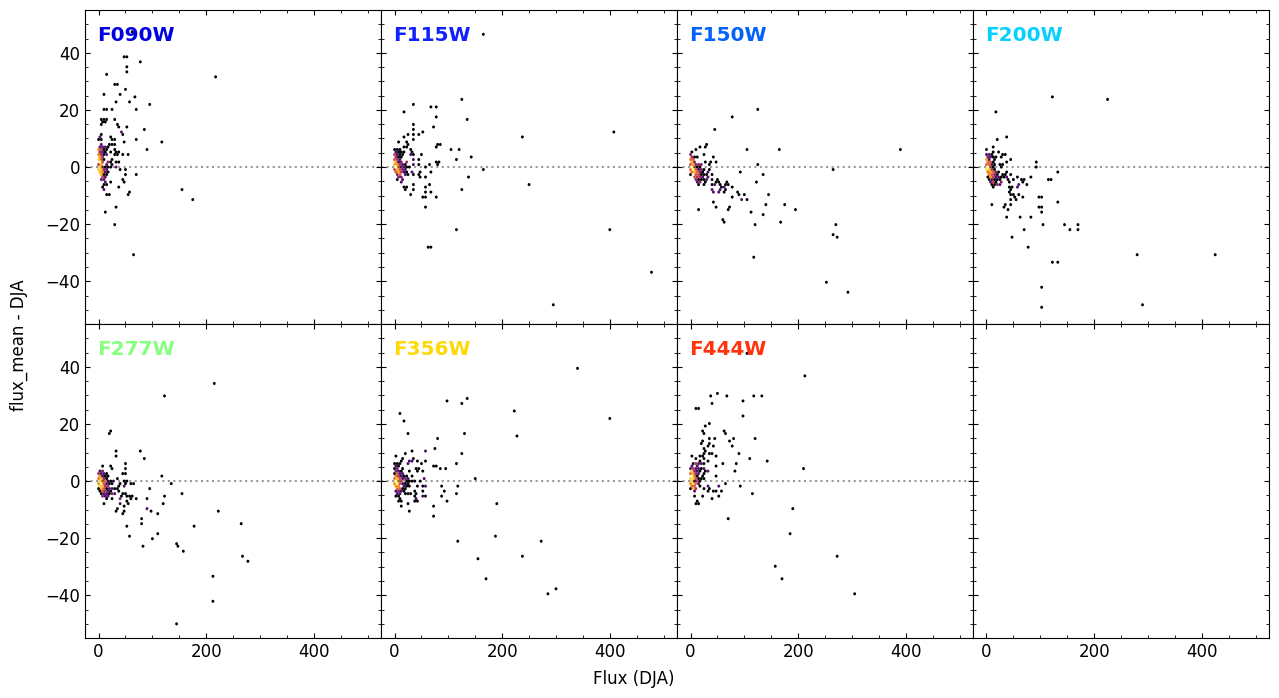

In [25]:
fig, axs = plt.subplots(h,w,figsize=(3*w+1,3*h+1), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

for i, filter in enumerate(filter_list):
    if (len(channel_count)==2) & (channel_dict[filter.upper()]=="LW"):
        i += max(0, channel_count["LW"]-channel_count["SW"])
    ax = axs.flatten()[i] if type(axs)==np.ndarray else axs

    ax.axhline(0, color='k', alpha=0.4, ls=':')
    flux_sepp = phot_sepp_match[f'FLUX_MODEL_{filter.upper()}']*10
    flux_assoc = phot_sepp_match['assoc_values'][:,3]*10
    flux_dja = phot_dja_match[f'{filter}_tot_1']*1000

    ax.hexbin(flux_dja, flux_assoc-flux_dja, mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0,500,-50,50), lw=0.01)
    ax.text(0.04, 0.9, filter.upper(), transform=ax.transAxes, fontsize='x-large', fontweight='bold', color=color_dict[filter.upper()])

fig.supylabel("flux_mean - DJA")
fig.supxlabel("Flux (DJA)")
fig.tight_layout(rect=(0.01, -0.02, 1.0, 1.0))
plt.show()